In [28]:
import os
import sys
from pathlib import Path

import cv2 as cv
import cv2
import h5py
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [29]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"
match_info_dir = data_dir / "match"

In [30]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils
import transform 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# experiment = "tonsil"
# core = "DonorA"
experiment = "endometrium"
core = "L11"
# experiment = "Lung"
# core = "B5"
datasets = [f'{core}_{i}' for i in range(1,7)]

# Import IMC data 

In [32]:
from functools import partial

import matplotlib.patches as mpatches
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate
from sklearn.preprocessing import MinMaxScaler

h5_data_dir = p_dir / "data" / "h5"


def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["markers"])
    return imgs, labels


def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs, labels


def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (0, 100))
    img_rescale = exposure.rescale_intensity(
        img, in_range=(p2, p98), out_range=(0, 255)
    ).astype(np.uint8)
    return img_rescale


# Read mask image
def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

def crop_img(img, info):
    # Rotate img
    y, h_region, x, w_region = info["bbox"]
    rotation = info["rotation_init"]
    rotation_small = info["rotation_adjust"]
    border = info["border"]

    img = rotate(img, rotation, resize=True)
    img = cv2.copyMakeBorder(
        img, border, border, border, border, cv2.BORDER_CONSTANT, None, value=0
    )
    img = contrast_stretching(img)
    
    # Get region for img
    if "img_region" in info.keys():
        row_min, row_max, col_min, col_max = info["img_region"]
        img = img[row_min:row_max, col_min:col_max]
        img = rotate(img, rotation_small, resize=True)
        
    if "affine" in info.keys():
        aff = info["affine"]
        pad = info["pad"]
        y = y - pad
        h_region = h_region + 2*pad
        x = x - pad
        w_region = w_region + 2*pad
        y = 0 if y < 0 else y
        x = 0 if x < 0 else x
        img_aff = img[y : y + h_region, x : x + w_region]
        img = transform.apply_global_affine(img_aff, img_aff, aff)
        y, h_region, x, w_region = info["bbox_aff"]
        
    img = img[y : y + h_region, x : x + w_region]
    return img


def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

In [33]:
# imgs_imc, markers = get_imgs(f"{experiment} {core}", "IMC")
# masks = get_masks(data_dir / "masks", f"{experiment}_{core}")

In [34]:
# import napari 

# napari.view_image(np.stack(imgs_imc), channel_axis=0, name=markers, visible=False)

# Extract expression level per cell

In [35]:
from skimage.measure import regionprops_table
from skimage.transform import resize


def get_region_props(img, mask, marker, prop):
    """
    Get regionprops from masked region
    """
    props = regionprops_table(mask, img, properties=prop)

    df_marker = pd.DataFrame(props)
    df_marker["Marker"] = marker
    df_marker["Id"] = regionprops_table(mask, properties=["label"])["label"]

    return df_marker


def extract_prop(imgs, labels, mask):
    appended_data_intensity = []

    for i, img in enumerate(imgs):
        df_marker = get_region_props(img, mask, labels[i], ["mean_intensity"])
        appended_data_intensity.append(df_marker)

        if i == 0:
            df_prop_morph = get_region_props(img, mask, labels[i], ["area", "centroid"])

    df_prop_intensity = pd.concat(appended_data_intensity, ignore_index=True)
    df_prop_intensity = df_prop_intensity.sort_values(by=["Id"]).reset_index(drop=True)

    # x_scaled = MinMaxScaler().fit_transform(df_prop_intensity[["mean_intensity"]])
    # df_prop_intensity["mean_intensity"] = x_scaled

    df_prop_morph = df_prop_morph.drop(["Marker"], axis=1)

    return df_prop_intensity, df_prop_morph


def extract_prop_ts(imgs, labels, mask):
    appended_data_intensity = []
    fov = mask.shape[0]
    imgs_stack = resize(imgs, (imgs.shape[0], fov, fov), order=2, preserve_range=True, anti_aliasing=False)
    mean = np.mean(imgs_stack, axis=0, keepdims=False)+1
    
    for i, img in enumerate(imgs_stack):
        img_normalized = img / mean
        # img_normalized = np.log(img_normalized + 1)
                
        df_marker = get_region_props(img_normalized, mask, labels[i], ["mean_intensity"])
        appended_data_intensity.append(df_marker)

        if i == 0:
            df_prop_morph = get_region_props(img, mask, labels[i], ["area"])

    df_prop_intensity = pd.concat(appended_data_intensity, ignore_index=True)
    df_prop_intensity = df_prop_intensity.sort_values(by=["Id"]).reset_index(drop=True)

    df_prop_morph = df_prop_morph.drop(["Marker"], axis=1)

    # x_scaled = MinMaxScaler().fit_transform(df_prop_intensity[["mean_intensity"]])
    # df_prop_intensity["mean_intensity"] = x_scaled

    return df_prop_intensity, df_prop_morph

In [36]:
masses = [
    50,
    190,
    191,
    193,
    194,
    196,
    198,
    200,
    201,
    202,
    203,
    55,
    204,
    205,
    206,
    207,
    208,
    209,
    210,
    212,
    214,
    216,
    56,
    217,
    220,
    221,
    222,
    223,
    224,
    225,
    226,
    229,
    232,
    57,
    236,
    238,
    240,
    243,
    246,
    248,
    249,
    250,
    252,
    253,
    58,
    254,
    256,
    259,
    261,
    263,
    265,
    267,
    269,
    273,
    275,
    59,
    276,
    279,
    282,
    289,
    301,
    307,
    308,
    310,
    318,
    60,
    328,
    332,
    339,
    344,
    353,
    359,
    369,
    380,
    385,
    397,
    61,
    412,
    424,
    431,
    436,
    448,
    457,
    468,
    474,
    479,
    498,
    63,
    501,
    510,
    514,
    518,
    520,
    529,
    544,
    552,
    570,
    586,
    64,
    593,
    610,
    1,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    16,
    76,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    17,
    87,
    88,
    91,
    93,
    95,
    96,
    97,
    98,
    100,
    102,
    30,
    104,
    105,
    107,
    109,
    111,
    112,
    115,
    116,
    117,
    118,
    34,
    121,
    122,
    124,
    125,
    127,
    128,
    131,
    133,
    134,
    138,
    35,
    140,
    141,
    143,
    144,
    145,
    146,
    148,
    149,
    150,
    151,
    42,
    153,
    155,
    156,
    158,
    159,
    161,
    162,
    164,
    165,
    166,
    44,
    167,
    168,
    169,
    170,
    171,
    173,
    179,
    182,
    184,
    185,
]
masses.sort()
masses = ["Total", "Rest"] + masses

In [37]:
masses_auto = [1.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.7, 21.7, 22.6, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 181.0, 182.0, 183.0, 184.9, 186.0, 187.0, 188.0, 189.0, 192.0, 193.9, 195.9, 197.0, 198.9, 200.9, 204.9, 208.9, 210.0, 216.9, 221.9, 228.9, 233.9, 237.9, 242.9, 253.3, 277.0, 325.2, 328.9, 343.8]

In [54]:
# core = "F7"
# datasets = [f'{core}_{i}' for i in range(1,6)]
masks = get_masks(data_dir / "masks", f"{experiment}_{core}")

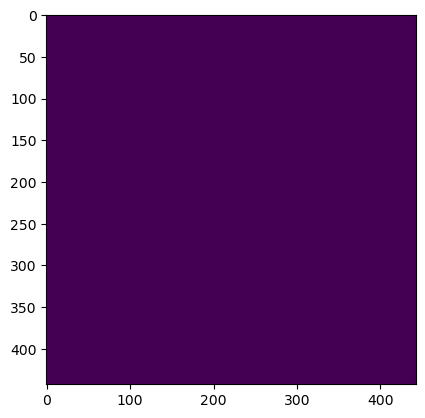

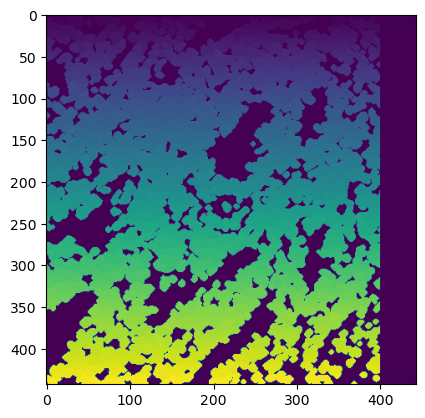

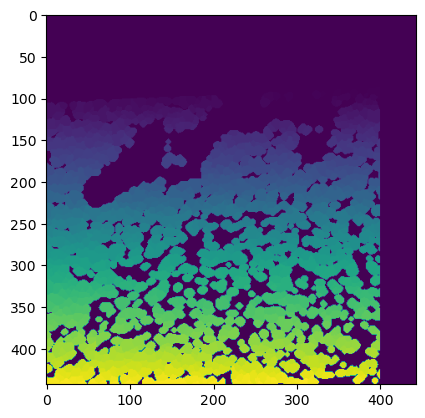

In [55]:
for i, dataset in enumerate(datasets):
    try:
        info = my_utils.load_pkl(match_info_dir / f"{experiment}_{dataset}.pickle")
    except:
        continue
    # imgs_imc, markers = get_imgs(f"{dataset}", "IMC")
    imgs_imc, markers = get_imgs(f"{core}", "IMC")

    # --- Read mask
    mask = masks["_".join([experiment, dataset])]
    
    if dataset in ['F7_1', 'F7_2']: # Correct the mask due to SIMS data
        mask[:,-90:] = 0
        
    if dataset in ['L11_2', 'L11_3']: # Correct the mask due to SIMS data
        mask[:,400:] = 0    
    
    plt.imshow(mask)
    plt.show()
    
    # --- Read IMC images
    func = partial(crop_img, info=info)
    imgs_cropped = joblib_loop(func, imgs_imc)

    # viewer = napari.view_image(imgs_cropped[-1], visible=False)
    # viewer.add_labels(mask)

    df_prop_intensity, df_prop_morph = extract_prop(imgs_cropped, markers, mask)
    df_prop_intensity = pd.pivot_table(
        df_prop_intensity, values="mean_intensity", index="Id", columns="Marker"
    )
    df_prop_intensity.to_csv(
        data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv"
    )
    df_prop_morph.to_csv(
        data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv", index=False 
    )

    # --- Read tof-sims images
    imgs, labels = get_imgs_sims(experiment, dataset)

    df_prop_intensity, df_prop_morph = extract_prop_ts(imgs, masses, mask)
    df_prop_intensity = pd.pivot_table(
        df_prop_intensity, values="mean_intensity", index="Id", columns="Marker"
    )
    df_prop_intensity.to_csv(
        data_dir / "props" / f"intensity_TS_{experiment}_{dataset}.csv"
    )
    
    # Read tof-sims auto images
    imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)

    df_prop_intensity, df_prop_morph = extract_prop_ts(imgs[2:], masses_auto, mask)
    df_prop_intensity = pd.pivot_table(
        df_prop_intensity, values="mean_intensity", index="Id", columns="Marker"
    )
    df_prop_intensity.to_csv(
        data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv"
    )